In [17]:
import numpy as np
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl

In [18]:
GPUkernel = """
#include <math.h>

__device__ bool intersect(float3 ro, float3 rd, float3 sphere_c, float  sphere_r, float &t_hit)
{
    float3 oc = make_float3(ro.x - sphere_c.x, ro.y - sphere_c.y, ro.z - sphere_c.z);
    float b   = oc.x*rd.x + oc.y*rd.y + oc.z*rd.z;  
    float c   = oc.x*oc.x + oc.y*oc.y + oc.z*oc.z - sphere_r*sphere_r;
    float disc = b*b - c;
    if(disc < 0.0f) 
    {
        return false;
    }
    float sqrt_disc = sqrtf(disc);
    float t0 = -b - sqrt_disc;
    float t1 = -b + sqrt_disc;
    if(t0 > 0.0f && t1 > 0.0f)
    {
        t_hit = fminf(t0, t1);
        return true;
    } 
    else if(t0 > 0.0f)
    {
        t_hit = t0;
        return true;
    } 
    else if(t1 > 0.0f)
    {
        t_hit = t1;
        return true;
    }
    return false;
}

__global__ void render(float *disp, int img_w, int img_h, float time)
{
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row >= img_h || col >= img_w)
        return;

    int pix_location = row * img_w * 3 + col * 3;
    
    float aspect_ratio = float(img_w) / float(img_h);

    float u = (2.0f * (col + 0.5f) / float(img_w) - 1.0f) * aspect_ratio;
    float v = 1.0f - 2.0f * (row + 0.5f) / float(img_h);

    float3 cam_pos = make_float3(0.0f, 0.0f, 0.0f);
    float3 ray_dir = make_float3(u, v, 1.0f);

    float length = sqrtf(ray_dir.x*ray_dir.x + ray_dir.y*ray_dir.y + ray_dir.z*ray_dir.z);
    ray_dir.x /= length;
    ray_dir.y /= length;
    ray_dir.z /= length;

    float3 sphere_center = make_float3(1.5f * sinf(time), 0.5f * cosf(time), 4.0f);
    float  sphere_radius = 1.0f;

    float3 bg_color = make_float3(0.0f, 0.0f, 0.0f);

    float t_hit;
    bool hit = intersect(cam_pos, ray_dir, sphere_center, sphere_radius, t_hit);

    float3 color;
    if(hit)
    {
        float3 hit_point = make_float3(
            cam_pos.x + t_hit * ray_dir.x,
            cam_pos.y + t_hit * ray_dir.y,
            cam_pos.z + t_hit * ray_dir.z
        );
        float3 normal = make_float3(
            hit_point.x - sphere_center.x,
            hit_point.y - sphere_center.y,
            hit_point.z - sphere_center.z
        );
        float n_len = sqrtf(normal.x*normal.x + normal.y*normal.y + normal.z*normal.z);
        normal.x /= n_len; normal.y /= n_len; normal.z /= n_len;

        float3 light_dir = make_float3(0.5f, 0.7f, -0.5f);
        float ld_len = sqrtf(light_dir.x*light_dir.x + light_dir.y*light_dir.y + light_dir.z*light_dir.z);
        light_dir.x /= ld_len; light_dir.y /= ld_len; light_dir.z /= ld_len;

        float3 sphere_base_color = make_float3(0.7f, 0.2f, 0.2f);
        float lambert = fmaxf(0.0f, normal.x*light_dir.x + normal.y*light_dir.y + normal.z*light_dir.z);

        color.x = sphere_base_color.x * lambert;
        color.y = sphere_base_color.y * lambert;
        color.z = sphere_base_color.z * lambert;
    }
    else
    {
        color = bg_color;
    }

    disp[pix_location + 0] = color.x;
    disp[pix_location + 1] = color.y;
    disp[pix_location + 2] = color.z;
}

"""

In [19]:
module = SourceModule(GPUkernel)
render = module.get_function("render")

img_w = 1920
img_h = 1080

n_pix = img_w * img_h
disp = np.zeros(3 * n_pix, dtype=np.float32)

threads = (16, 16, 1)
blocks = ((threads[0] + img_w - 1) // threads[0], (threads[1] + img_h - 1) // threads[1])

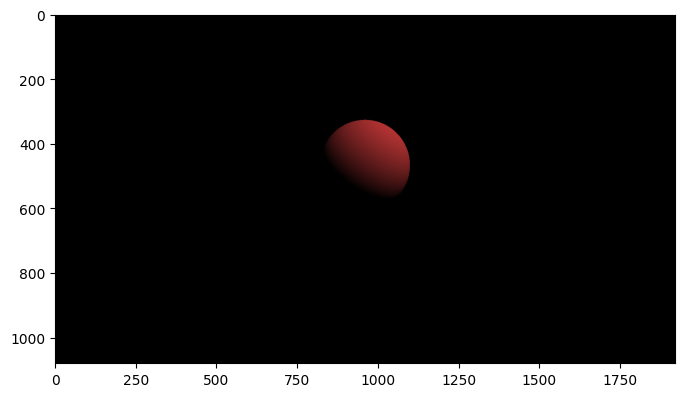

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
img_plot = ax.imshow(np.zeros((img_h, img_w, 3)))

def animate(frame):
    time = frame * 0.1
    render(drv.Out(disp), np.int32(img_w), np.int32(img_h), np.float32(time), block=threads, grid=blocks)
    img_data = disp.reshape(img_h, img_w, 3)
    img_plot.set_array(img_data)
    return [img_plot]

res = FuncAnimation(fig, animate, frames=50, interval=50, blit=True)

In [21]:
res.save('/mnt/d/CUDA/day36/intersection.gif', writer='pillow', fps=20)